# Imports

In [1]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
import keras.ops
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras import Loss
import seaborn as sns

2025-03-24 15:35:21.995780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742830522.021958    3531 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742830522.028375    3531 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 15:35:22.054147: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Train on single vehicle dynamics

## Constant coefficient car

In [4]:
class SecondOrderCar:
    def __init__(self, x0: tuple, m: float, Af: float, to_estimate: tuple):
        #vehicle params:
        # known
        self.m = m
        self.Af = Af
        #unkowns
        self.road_grade, self.c0, self.c1, self.p, self.Cd = to_estimate

        self.X = np.array(x0, dtype=float) #[position, velocity]

        self.history = {
            "x": [], "v": [], "u": [], "a": []
        }

    def update(self, u, dt):
        """Update state for one time step using fixed-step integration"""

        # Store history
        self.history['x'].append(self.X[0])
        self.history['v'].append(self.X[1])
        self.history['u'].append(u)


        # Rk4
        k1 = self._dynamics(self.X, u)
        a = k1[1] #gets v_dot = actual acceleration
        self.history["a"].append(a)

        k2 = self._dynamics(self.X + 0.5*dt*k1, u)
        k3 = self._dynamics(self.X + 0.5*dt*k2, u)
        k4 = self._dynamics(self.X + dt*k3, u)

        self.X += (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

    def _dynamics(self, X, u):
        '''Vehicle Dynamics in State-Space form'''
        g = 9.81
        x, v = X
        Fr = (self.c0 + self.c1 * v)*(self.m*g*np.cos(self.road_grade))
        Fa = (self.p*self.Cd*self.Af*v**2)/2
        Fg = self.m*g*np.sin(self.road_grade)

        a = (u - Fr - Fa - Fg)/self.m #Assumes instant actuation u (traction force)
        return np.array([v, a])


## Generate synthetic data

In [5]:
# random value from https://www.chegg.com/homework-help/questions-and-answers/top-speed-vehicle-analytical-toolbox-consider-typical-sedan-car-following-parameters-mass--q109159050
x0 = (0, 20/3.6) #at origin and 20km/h
m = 1500 #kg toyota prius 2001 curb weight
# https://en.wikipedia.org/wiki/Automobile_drag_coefficient
Af = 2.1 # average drag (cross sectional) area
Cd = 0.27 #toyota prius 2001
p = 1.204 #average air density
#rolling resistance:
c0 = 0.0075
c1 = 2*10**-4
road_grade = np.atan(2/100) #in radians, 2% slope
to_estimate = (road_grade, c0, c1, p, Cd)

car = SecondOrderCar(x0, m, Af, to_estimate)
t_end = 300
dt = 0.1
t = np.arange(0, t_end+dt, dt)

#DEFINE U
t_samp = np.array([0, 40, 100, 200, 250, t_end]) #time check points
u_samp_train = np.array([0.5, 0.5, -0.1, 0.4, 0.3, 0.1]) * m # traction force (input from engine)
u = interp1d(t_samp, u_samp_train, kind='linear') #quadratic interpolation -> no drivetrain limitation for now

#generate data:
for t_curr in t:
    car.update(u(t_curr), dt)

# for validation later (different trajectory):

### Simulate measurements (add noise)

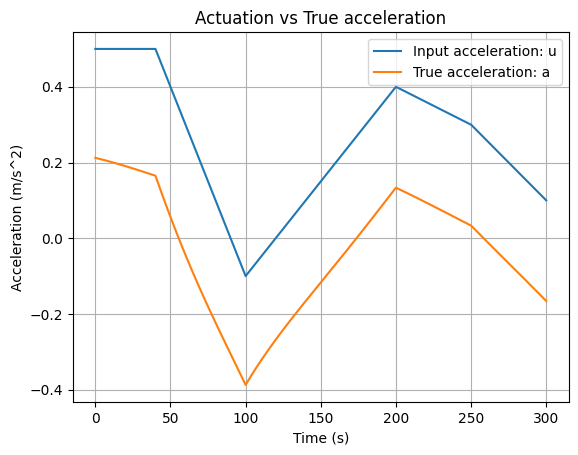

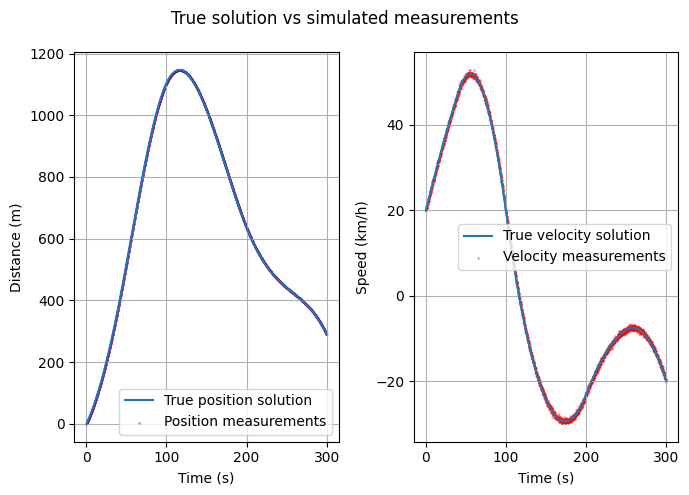

In [6]:
variance = 0.1

x_true = np.array(car.history["x"]).reshape(-1, 1)
v_true = np.array(car.history["v"]).reshape(-1, 1)
Y_true = np.hstack((x_true, v_true))
Y_noise = Y_true + np.random.normal(0, variance, size=Y_true.shape)

plt.plot(t, np.array(car.history["u"])/car.m, label = "Input acceleration: u")
plt.plot(t, car.history["a"], label="True acceleration: a")
plt.title("Actuation vs True acceleration")
plt.grid()
plt.legend();
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
fig = plt.figure(figsize=(7,5))
fig.suptitle("True solution vs simulated measurements")
ax=fig.subplots(1,2)
ax[0].plot(t, Y_true[:, 0], label="True position solution")
ax[0].scatter(t, Y_noise[:, 0], label="Position measurements", s=0.1, color="purple")
ax[0].set_ylabel("Distance (m)")
ax[1].plot(t, Y_true[:, 1]*3.6, label="True velocity solution")
ax[1].scatter(t, Y_noise[:, 1]*3.6, label="Velocity measurements", s=0.1, color="red")
ax[1].set_ylabel("Speed (km/h)")
for i in range(len(ax)):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel("Time (s)")
fig.tight_layout()

## Forward Problem

In [7]:
def comparison_plot(t: np.ndarray, true_data: np.ndarray, meas_data: np.ndarray,
                     pred_data: list[tuple[np.ndarray, str]], suptitle: str):
    # Plot the true vs predicted values for position and velocity:
    plt.figure(figsize=(12, 8))
    plt.suptitle(suptitle)

    # Plot for position:
    plt.subplot(1, 2, 1)
    plt.plot(t, true_data[:, 0], label="True Position", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 0], '--', label=label, linewidth=2)
    plt.scatter(t, meas_data[:, 0], label="Measured position points", s=7, color="red")
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    # Plot for velocity:
    plt.subplot(1, 2, 2)
    plt.plot(t, true_data[:, 1] * 3.6, label="True Velocity", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 1] * 3.6, '--', label=label, linewidth=2)
    plt.scatter(t, meas_data[:, 1] * 3.6, label="Measured velocity points", s=7, color="red")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (km/h)")
    plt.title("Velocity")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def loss_plot(history):
    loss = history["loss"]
    val_loss = history["val_loss"]
    stopped_epoch = np.argmin(val_loss) + 1  # Get the epoch with the minimum validation loss

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss) + 1), loss, label="Training Loss")
    plt.plot(range(1, len(loss) + 1), val_loss, label="Validation Loss (against ground truth)")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.title("Evolution of training and validation losses")

    # Add a marker for the early stopping epoch
    plt.axvline(x=stopped_epoch, color='r', linestyle='--', label='Early Stopping')
    plt.text(stopped_epoch, val_loss[stopped_epoch - 1], f'({stopped_epoch}, {val_loss[stopped_epoch - 1]:.5e})',
             color='b', fontsize=12)

    plt.legend()
    plt.show()

# Prepping data

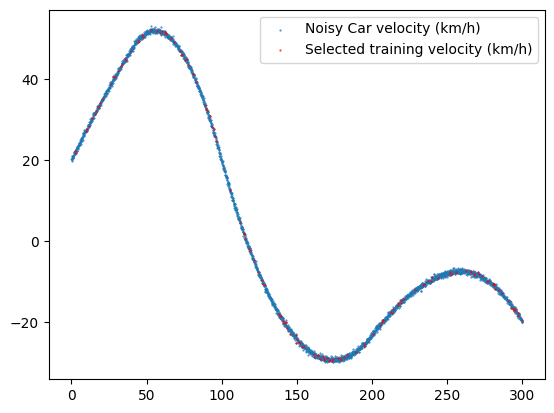

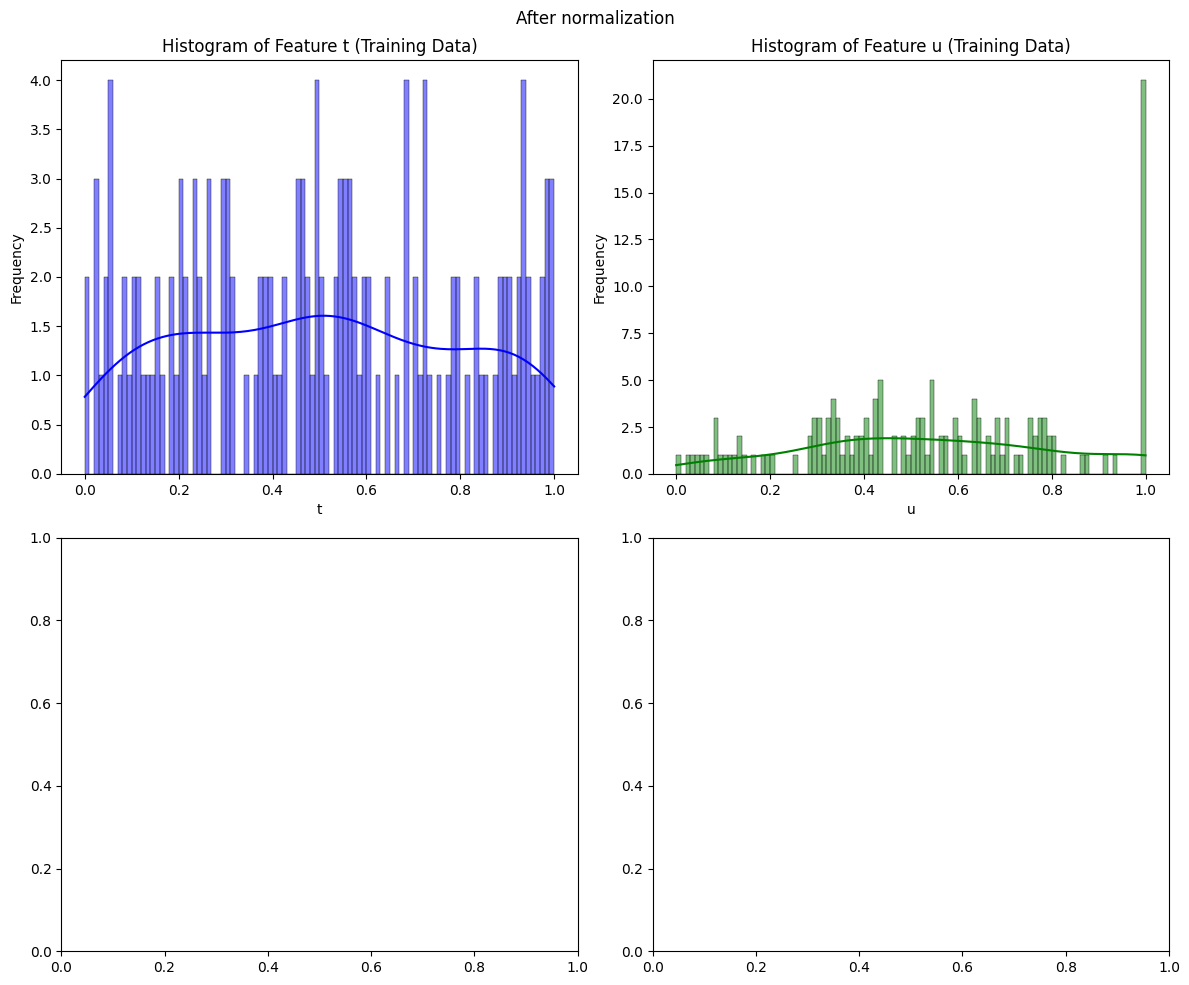

In [8]:
# prepping the data
train_ratio = .05
X = np.stack([t, u(t)], axis=-1) #t and u as features

Y_train, Y_test, X_train, X_test = train_test_split(Y_noise, X, train_size=train_ratio, random_state=31)
#print(Y_train.shape) #only 10% of measurements (sparse dataset)

#Visualize training data provided to model:
mask = np.isin(Y_noise, Y_train)
Y_mask = Y_noise.copy()
Y_mask[~mask] = np.nan
plt.scatter(t, Y_noise[:, 1] * 3.6, label="Noisy Car velocity (km/h)", s=.2)
plt.scatter(t, Y_mask[:, 1] * 3.6, label="Selected training velocity (km/h)", s=.2, color="red")
plt.legend()
plt.show()

#Prediction Normalization
# if we dont do this, position contributes more to the loss, due to the sheer inbalance of scale
""" scaler_Y = StandardScaler().fit(Y_train)
Y_train_norm = scaler_Y.transform(Y_train)
Y_test_norm = scaler_Y.transform(Y_test)
Y_true_norm = scaler_Y.transform(Y_true)
y_0_norm = Y_true_norm[0, :] """

# feature normalization all based on the training distribution
scaler_X = MinMaxScaler().fit(X_train)
X_train_norm = scaler_X.transform(X_train)
X_test_norm = scaler_X.transform(X_test)
X_norm = scaler_X.transform(X)
x_0_norm = X_norm[0, :]

# Plot histograms for features and outputs using seaborn
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("After normalization")

# Plot histograms for features
sns.histplot(X_train_norm[:, 0], bins=100, kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Histogram of Feature t (Training Data)')
axes[0, 0].set_xlabel('t')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(X_train_norm[:, 1], bins=100, kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title('Histogram of Feature u (Training Data)')
axes[0, 1].set_xlabel('u')
axes[0, 1].set_ylabel('Frequency')

""" # Plot histograms for outputs
sns.histplot(Y_train_norm[:, 0], bins=100, kde=True, ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Histogram of Output Position (Label Data)')
axes[1, 0].set_xlabel('Position')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(Y_train_norm[:, 1], bins=100, kde=True, ax=axes[1, 1], color='red')
axes[1, 1].set_title('Histogram of Output Velocity (Label Data)')
axes[1, 1].set_xlabel('Velocity')
axes[1, 1].set_ylabel('Frequency') """

plt.tight_layout()
plt.show()

# PUNN-only

I0000 00:00:1742830584.422490    3531 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1989 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


Epoch 1/2000


I0000 00:00:1742830588.187347    3786 service.cc:148] XLA service 0x7f44b0003e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742830588.187961    3786 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2025-03-24 15:36:28.273090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742830588.536399    3786 cuda_dnn.cc:529] Loaded cuDNN version 90300


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 256217.5938

I0000 00:00:1742830589.843917    3786 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - loss: 257754.2500 - val_loss: 263374.1562
Epoch 2/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 266313.6875 - val_loss: 262254.6250
Epoch 3/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 257555.7812 - val_loss: 260783.3281
Epoch 4/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 242513.6250 - val_loss: 259243.0938
Epoch 5/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 245211.0469 - val_loss: 257969.0469
Epoch 6/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 276804.3750 - val_loss: 257082.4375
Epoch 7/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 275395.2188 - val_loss: 256437.7656
Epoch 8/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 252073.2500 - val_loss: 255913.4531
Epoch 9/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 275966.9375 - val_loss: 255438.5469
Epoch 10/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 230158.2812 - val_loss: 255003.4531
Epoch 11/2000
10/10 ━━━━━━━━━━━━━━━━━

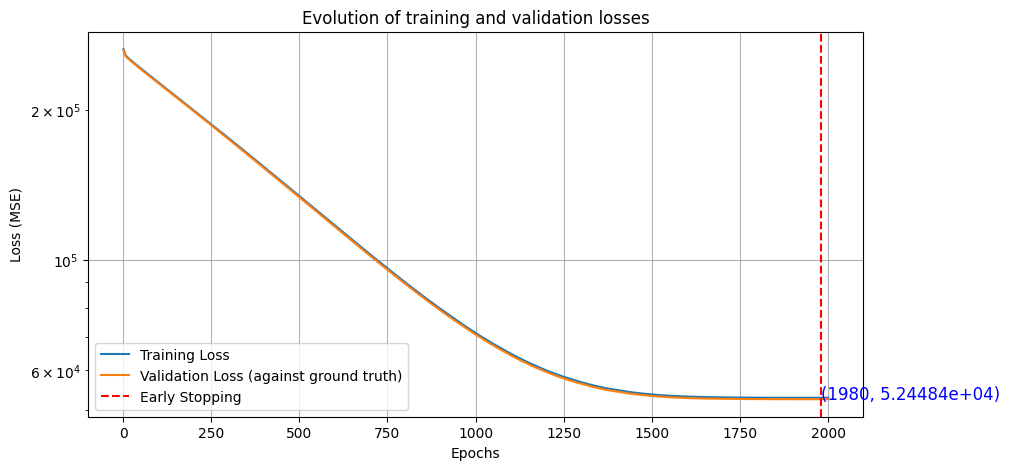

In [ ]:
#globals
#------
n_hid_layers = 3
n_neurons = 50
act = "tanh"
epochs = 2000
metrics = []
opt = Adam(learning_rate=0.001, weight_decay=1e-3)
loss = "mse"
patience = 50
#------

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
def lr_schedule(epoch, lr):
    if (epoch+1) % 250 == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath='pinn_model_forward.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

#PUNN
punn_model = Sequential()
punn_model.add(Input(shape=(2, ))) #input: t,u
for _ in range(0,n_hid_layers):
    punn_model.add(Dense(n_neurons, activation=act))
punn_model.add(Dense(2, activation="linear")) #output layer -> p^ and v^
punn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#punn_model.summary()
#with output scaling:
history_punn_fwd = punn_model.fit(x=X_train_norm, y=Y_train, validation_data=(X_norm, Y_true),
                                  batch_size=16, epochs=epochs, callbacks=[early_stopping, lr_scheduler, checkpoint] verbose=True)
loss_plot(history_punn_fwd.history)

In [ ]:
punn_model.save("punn_model_forward.h5")

## PUNN predictions
Very nice for training u but change it and see the model totally fail :-)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Normalized MSE overall: 8.27823e+04
Normalized MSE for position: 1.65505e+05
Normalized MSE for velocity: 5.93884e+01


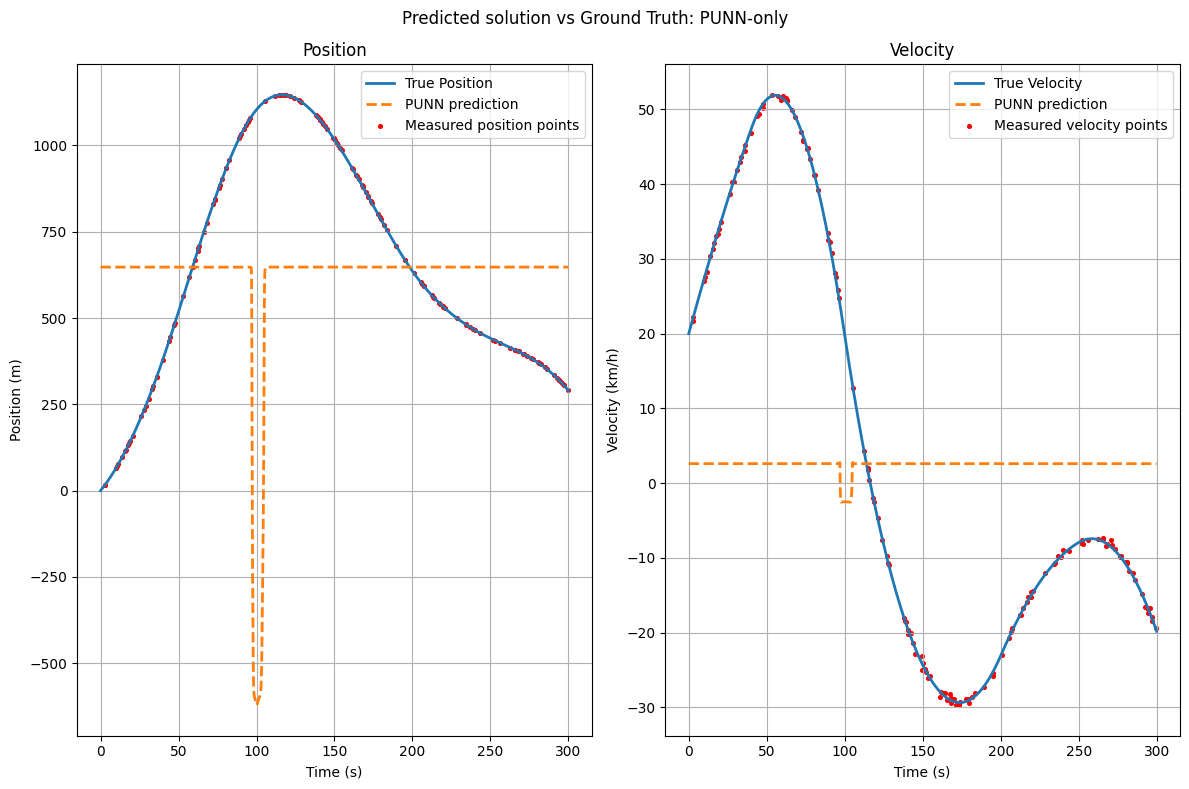

In [10]:
#punn_model = load_model("punn_model_forward.h5", compile=False) #load model just for prediction
#predictions for full t range
predictions = punn_model.predict(X)   #predictions shape will be (3000, 2)
mse_total = mean_squared_error(Y_true, predictions)
mse_x = mean_squared_error(Y_true[:, 0], predictions[:, 0])
mse_v = mean_squared_error(Y_true[:, 1], predictions[:, 1])
print(f"Normalized MSE overall: {mse_total:.5e}")
print(f"Normalized MSE for position: {mse_x:.5e}")
print(f"Normalized MSE for velocity: {mse_v:.5e}")

comparison_plot(t, Y_true, Y_mask, [(predictions, "PUNN prediction")], "Predicted solution vs Ground Truth: PUNN-only")


# PINN

In [ ]:
collocation_size = len(t) #trying to increase collocation poins for better physics convergence
t_c = np.linspace(start=0, stop=t_end, num=collocation_size) #collocation points -> uniform sampling for now
u_c = u(t_c)
X_c = np.stack([t_c, u_c], axis=-1)
X_c_norm = scaler_X.transform(X_c)

class CombinedLoss(Loss):
    def __init__(self, car, model: keras.Model, X_c_norm: np.ndarray, y_0_norm: np.ndarray, x_0_norm: np.ndarray,
                 scaler_X: MinMaxScaler, scaler_Y, loss_weights: tuple[float, float, float]):
        super().__init__()
        self.car = car
        self.model = model
        self.alpha_d, self.alpha_p, self.alpha_b = loss_weights

        #initial conditions
        self.y_0_norm = y_0_norm
        self.x_0_norm = x_0_norm
        self.scaler_Y = scaler_Y
        self.scaler_X = scaler_X

        # Convert to tensor and separate components
        X_c_norm = tf.convert_to_tensor(X_c_norm, dtype=tf.float32)
        self.t_c_norm = X_c_norm[:, 0]  # normalized time collocation points
        # Stop gradient for u component to prevent physics contamination
        self.u_c_norm_fixed = tf.stop_gradient(X_c_norm[:, 1])
        self.X_c_norm_fixed = tf.stack([self.t_c_norm, self.u_c_norm_fixed], axis=-1)

        # Precompute denormalized u values for physics equations
        X_c_denorm = scaler_X.inverse_transform(X_c_norm)
        self.u_phy = X_c_denorm[:, 1]  # physical u values for collocation points

    def data_loss(self, y_true, y_pred):
        """Calculate MSE between predictions and measurements"""
        sqr_diff = tf.square(y_true - y_pred)
        return tf.reduce_mean(sqr_diff)

    def physics_loss(self):
        """Calculate PDE residual loss using automatic differentiation"""
        g = 9.81
        car = self.car

        with tf.GradientTape(persistent=True) as tape:
            # Watch the entire input tensor but u has stopped gradients
            tape.watch(self.X_c_norm_fixed)
            y_norm = self.model(self.X_c_norm_fixed)
            y_norm_x = y_norm[:, 0]  # normalized position prediction
            y_norm_v = y_norm[:, 1]  # normalized velocity prediction

        # Compute gradients for both outputs w.r.t all inputs
        grad_x_norm = tape.gradient(y_norm_x, self.X_c_norm_fixed)
        grad_v_norm = tape.gradient(y_norm_v, self.X_c_norm_fixed)
        del tape  # Explicitly delete persistent tape

        # Extract time derivatives (u gradients are zero due to stop_gradient)
        dx_dt_norm = grad_x_norm[:, 0]  # position derivative w.r.t normalized time
        dv_dt_norm = grad_v_norm[:, 0]  # velocity derivative w.r.t normalized time

        # Denormalize outputs using StandardScaler parameters
        y_phy = y_norm * self.scaler_Y.scale_ + self.scaler_Y.mean_
        v_phy = y_phy[:, 1]  # physical velocity

        # Get scaling factors from MinMaxScaler
        t_scale = self.scaler_X.scale_[0]  # time normalization scale factor

        # Convert normalized derivatives to physical units
        dx_dt = dx_dt_norm * t_scale * self.scaler_Y.scale_[0]
        dv_dt = dv_dt_norm * t_scale * self.scaler_Y.scale_[1]

        # Calculate resistance forces using vehicle parameters
        Fr = (car.c0 + car.c1 * v_phy) * (car.m * g * np.cos(car.road_grade))
        Fa = (car.p * car.Cd * car.Af * v_phy**2) / 2
        Fg = car.m * g * np.sin(car.road_grade)

        # Compute physics residuals
        res_x = dx_dt - v_phy  # dx/dt should equal velocity
        res_v = car.m * dv_dt - (self.u_phy - Fr - Fa - Fg)  # Newton's law

        # Combine and average residuals
        res = tf.stack([res_x, res_v], axis=1)
        return tf.reduce_mean(tf.square(res))

    def boundary_loss(self):
        """Enforce initial condition matching"""
        y0_pred = self.model(self.x_0_norm[tf.newaxis, :])
        sqr_diff = tf.square(y0_pred - self.y_0_norm)
        return tf.reduce_mean(sqr_diff)

    def call(self, y_true, y_pred):
        """Combine loss components with weighting factors"""
        data_loss = self.data_loss(y_true, y_pred)
        pde_loss = self.physics_loss()
        bound_loss = self.boundary_loss()

        return (
            self.alpha_d * data_loss +
            self.alpha_p * pde_loss +
            self.alpha_b * bound_loss
        )

## Combined Loss

In [ ]:
collocation_size = X_train_norm.shape[0] #same length as training time instants (for now)
t_c = np.linspace(start=0, stop=t_end, num=collocation_size) #collocation points -> uniform sampling for now
u_c = u(t_c)
X_c = np.stack([t_c, u_c], axis=-1)
X_c_norm = scaler_X.transform(X_c)

class CombinedLoss(Loss):
    def __init__(self, car, model: keras.Model, X_c_norm: np.ndarray, y_0_norm: np.ndarray, x_0_norm: np.ndarray,
                 scaler_X: MinMaxScaler, scaler_Y, loss_weights: tuple[float, float, float]):
        super().__init__()
        self.car = car
        self.model = model
        self.alpha_d, self.alpha_p, self.alpha_b = loss_weights

        #initial conditions
        self.y_0_norm = y_0_norm
        self.x_0_norm = x_0_norm
        self.scaler_Y = scaler_Y
        self.scaler_X = scaler_X


        X_c_norm = tf.convert_to_tensor(X_c_norm, dtype=tf.float32)
        self.t_c_norm = X_c_norm[:, 0]  # normalized time collocation points
        #avoid u (punn input) to pollute dt calculations
        self.u_c_norm_fixed = tf.stop_gradient(X_c_norm[:, 1])
        self.X_c_norm_fixed = tf.stack([self.t_c_norm, self.u_c_norm_fixed], axis=-1)

        # u for plugging into equations
        X_c_denorm = scaler_X.inverse_transform(X_c_norm)
        self.u_phy = X_c_denorm[:, 1]


    def data_loss(self, y_true, y_pred):
        sqr_diff = keras.ops.square(y_true - y_pred)
        return keras.ops.mean(sqr_diff)

    def physics_loss(self):
        g = 9.81
        car = self.car

        with tf.GradientTape(persistent=True) as tape: #automatic differentiation
            tape.watch(self.t_c_norm) #record gradients for all time collocation points (normalized)
            #we need the model for prediction since collocation points might not be training points!
            y_norm = self.model(self.X_c_norm_fixed)
            y_norm_x = y_norm[:, 0] #need these variables so that the tape keeps track
            y_norm_v = y_norm[:, 1]

        # norm gradients w.r.t normalized inputs
        dx_dt_norm = tape.gradient(y_norm_x, self.t_c_norm)
        dv_dt_norm = tape.gradient(y_norm_v, self.t_c_norm)
        del tape

        y_phy = y_norm * self.scaler_Y.scale_ + self.scaler_Y.mean_ # Denormalize (standard scaler)
        v_phy = y_phy[:, 1]

         # Time scaling factor from MinMaxScaler, t_norm = t*scale + t_min
        t_scale = self.scaler_X.scale_[0]  # scale = (norm_max-norm_min)/(t_max - t_min)

        # Compute real-time derivatives using the chain rule
        dx_dt = dx_dt_norm * t_scale * scaler_Y.scale_[0]  # dx/dt = dx_norm/dt_norm * dt_norm/dt * dx/dx_norm
        dv_dt = dv_dt_norm * t_scale * scaler_Y.scale_[1]  # same for dv/dt

        Fr = (car.c0 + car.c1*v_phy)*(car.m*g*np.cos(car.road_grade))
        Fa = (car.p*car.Cd*car.Af*v_phy**2)/2
        Fg = car.m*g*np.sin(car.road_grade)

        res_x = dx_dt-v_phy
        res_v = car.m * dv_dt - (self.u_phy - Fr - Fa - Fg)
        res = keras.ops.stack([res_x, res_v], axis=-1)

        sqr_diff = keras.ops.square(res)
        return keras.ops.mean(sqr_diff)

    def boundary_loss(self):
        y0_pred = self.model(self.x_0_norm[np.newaxis, :]) # add None: batch dimension
        sqr_diff = keras.ops.square(y0_pred - self.y_0_norm)
        return keras.ops.mean(sqr_diff)

    def call(self, y_true, y_pred):
        data_loss = self.data_loss(y_true, y_pred)
        pde_loss = self.physics_loss()
        bound_loss = self.boundary_loss()

        return self.alpha_d*data_loss + self.alpha_p*pde_loss + self.alpha_b*bound_loss


## Training

In [ ]:
#globals
#------
n_hid_layers = 3
n_neurons = 50
act = "tanh"
epochs = 5000
patience = 50
metrics = []
opt = Adam(learning_rate=0.001, weight_decay=1e-3)
alpha_d = 1
alpha_p = 1
alpha_b = 0
alpha = alpha_d, alpha_p, alpha_b #weights for different loss components
#------

#PINN
pinn_model = Sequential()
pinn_model.add(Input(shape=(2, ))) #input: t and u
for _ in range(0,n_hid_layers):
    pinn_model.add(Dense(n_neurons, activation=act))
pinn_model.add(Dense(2, activation="linear")) #output layer -> p^ and v^
loss = CombinedLoss(car=car, model=pinn_model, X_c_norm=X_c_norm, scaler_X=scaler_X,
                    scaler_Y=scaler_Y, loss_weights=alpha, x_0_norm=x_0_norm, y_0_norm=y_0_norm)
pinn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#pinn_model.summary()

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
def lr_schedule(epoch, lr):
    if (epoch+1) % 250 == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath='pinn_model_forward.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

#training
history_pinn_fwd = pinn_model.fit(x=X_train_norm, y=Y_train_norm, validation_data=(X_norm,Y_true_norm),
                                  batch_size=16, epochs=epochs, callbacks=[early_stopping, lr_scheduler, checkpoint], verbose=True)
loss_plot(history_pinn_fwd.history)

In [ ]:
pinn_model.save("pinn_model_forward_best.h5")

# PUNN vs PINN

In [ ]:
''' #PUNN
#punn_model = load_model("punn_model_forward.h5", compile=False) #load model just for prediction
#predictions for full t range
print("---PUNN---")
punn_norm = punn_model.predict(X_norm)   #predictions shape will be (3000, 2)
punn_mse_total = mean_squared_error(Y_true_norm, punn_norm)
punn_mse_x = mean_squared_error(Y_true_norm[:, 0], punn_norm[:, 0])
punn_mse_v = mean_squared_error(Y_true_norm[:, 1], punn_norm[:, 1])
print(f"Normalized MSE overall: {punn_mse_total:.5e}")
print(f"Normalized MSE for position: {punn_mse_x:.5e}")
print(f"Normalized MSE for velocity\n: {punn_mse_v:.5e}")

punn = scaler_Y.inverse_transform(punn_norm) #denormalize for true trajectories
 '''
#PINN
print("---PINN---")
#pinn_model = load_model("pinn_model_forward.h5", compile=False) #load model just for prediction
#predictions for full t range
pinn_norm = pinn_model.predict(X_norm)   #y shape will be (3000, 2)
pinn_mse_total = mean_squared_error(Y_true_norm, pinn_norm)
pinn_mse_x = mean_squared_error(Y_true_norm[:, 0], pinn_norm[:, 0])
pinn_mse_v = mean_squared_error(Y_true_norm[:, 1], pinn_norm[:, 1])
print(f"Normalized MSE overall: {pinn_mse_total:.5e}")
print(f"Normalized MSE for position: {pinn_mse_x:.5e}")
print(f"Normalized MSE for velocity: {pinn_mse_v:.5e}")

pinn = scaler_Y.inverse_transform(pinn_norm) #denormalize for true trajectories

comparison_plot(t, Y_true, Y_mask, [(pinn, "PINN prediction")],  suptitle="Predicted solution vs Ground Truth: PINN")
